In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

import scienceplots
plt.style.use("science")

from astropy.modeling.models import BlackBody
from astropy import units as u

from astropy.visualization import quantity_support
quantity_support()

from specutils import Spectrum1D, SpectralRegion

DATA_DIR = "/home/ramon/uanl/thesis/Backup Data/Szkody APO Spectra"
os.listdir(DATA_DIR)

['combined-spectrum', 'single-spectra', 'f23s.fits', 'f24s.fits']

In [46]:
import pandas as pd

from specutils.analysis import snr_derived

USE_SINGLE_SPECTRUM = False
spec: Spectrum1D = None

noise_region = SpectralRegion(4500*u.AA, 7000*u.AA)

if USE_SINGLE_SPECTRUM:
	print("Single spectrum")
	fitsPath = os.path.join(DATA_DIR, os.listdir(DATA_DIR)[0])
	spec = Spectrum1D.read(fitsPath)
else:
	print("Using spectra sum")
	
	combinedSpecDir = os.path.join(DATA_DIR, "combined-spectrum")
	combinedSpecPath = os.path.join(combinedSpecDir, "combined.fits")

	individualSpecDir = os.path.join(DATA_DIR, "single-spectra")
	os.makedirs(individualSpecDir, exist_ok=True)
	
	for f in os.listdir(DATA_DIR):
		if os.path.isdir(os.path.join(DATA_DIR, f)):
			continue

		s: Spectrum1D = Spectrum1D.read(os.path.join(DATA_DIR, f))

		print(f"{f} SNR = {snr_derived(s, noise_region)}")

		# writing out csv files for use in PyHammer
		sDf = pd.DataFrame(data={"wavelength": s.wavelength, "flux": s.flux})
		sDf.to_csv(os.path.join(individualSpecDir, f.replace(".fits", ".csv")), index=False, header=False)

		if spec is None:
			spec = s
		else:
			spec += s

	spec /= 2
	print(f"Averaged spectrum SNR = {snr_derived(spec, noise_region)}")

	os.makedirs(combinedSpecDir, exist_ok=True)
	spec.write(combinedSpecPath, format='wcs1d-fits', overwrite=True)

	manualSpecDf = pd.DataFrame(data={"wavelength": spec.wavelength, "flux": spec.flux})
	manualSpecDf.to_csv(os.path.join(combinedSpecDir, "Averaged Spectrum.csv"), index=False, header=False)

Using spectra sum
f23s.fits SNR = 38.98427908164556
f24s.fits SNR = 39.542717239365736
Averaged spectrum SNR = 50.943324032544155


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


# Spectra Phase

Determining at which phase each spectrum was taken, to determine contribution from individual components.

In [5]:
# read ZTF data for timing data; only need one to read in and plot in phase
# using ZTF:r data since starspot is more obvious in this passband
from astropy.table import Table
from astropy.timeseries import TimeSeries
from astropy.time import Time

rData = Table.read("/home/ramon/uanl/thesis/Backup Data/IRSA/rel-zr-flux.ecsv")

ztfPeriod = (0.3335660396161509) * u.day # second harmonic
t0_supconj = (0.02589) * u.day

ztfTs = TimeSeries(time=Time(val=rData['hjd'], scale='utc', format='jd'), data={'mag': rData['mag'], 'flux': rData['flux']})
foldedZtfTs = ztfTs.fold(period=ztfPeriod, epoch_time=Time(t0_supconj, format='jd', scale='utc'), normalize_phase=True)
foldedZtfTs.to_pandas()

/home/ramon/anaconda3/envs/mapta-tesis/lib/python3.12/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


,mag,flux
time,,
-0.055489,16.912392,1.580218
-0.092119,16.807243,1.740910
-0.322063,16.709082,1.905640
-0.192006,16.687393,1.944090
-0.101355,16.800165,1.752296
...,...,...
0.008775,17.045118,1.398383
-0.005639,17.073063,1.362851
0.004063,17.057766,1.382188


In [4]:
from astropy.coordinates import EarthLocation, SkyCoord

apoLoc = EarthLocation.of_site("Apache Point Observatory")
atoCoord = SkyCoord.from_name("ATO J339.9469+45.1464")
apoLoc, atoCoord

(<EarthLocation (-1463969.30185172, -5166673.34223433, 3434985.71204565) m>,
 <SkyCoord (ICRS): (ra, dec) in deg
     (339.94690379, 45.14639753)>)

2023-12-04T03:41:13.242 9.999999999999964 min
2023-12-04T03:52:37.339 9.999999999999964 min


/home/ramon/anaconda3/envs/mapta-tesis/lib/python3.12/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


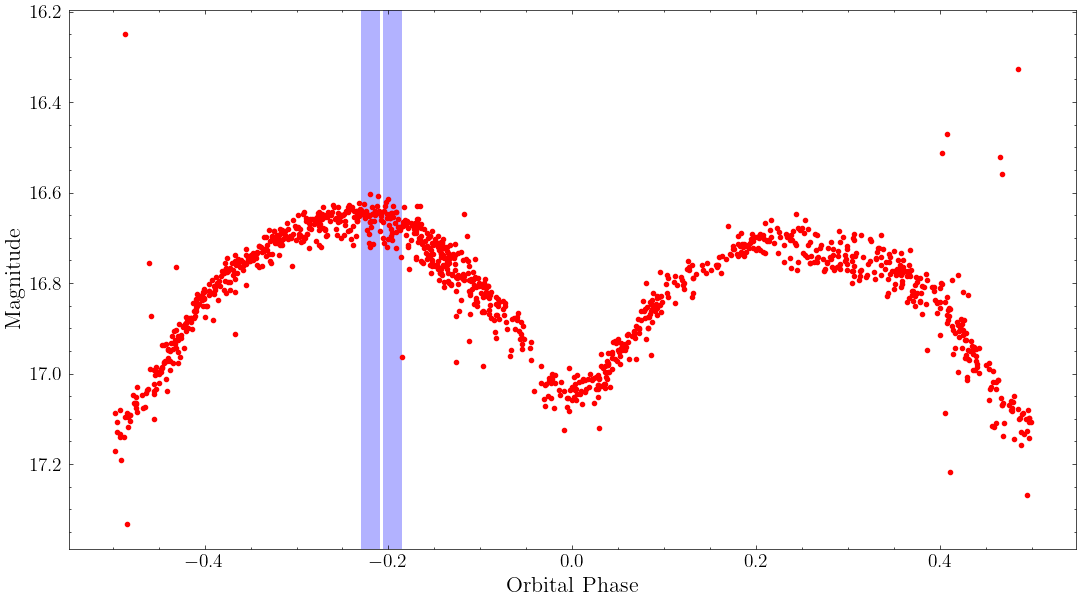

In [10]:
import matplotlib.pyplot as plt
from astropy.io import fits

plt.figure(figsize=(13, 7))
plt.plot(foldedZtfTs.time, foldedZtfTs['mag'], marker='.', linestyle='none', color='red')

for f in os.listdir(DATA_DIR):
	if os.path.isdir(os.path.join(DATA_DIR, f)):
		continue
	
	specHdul = fits.open(os.path.join(DATA_DIR, f))[0]
	specUtcTimeObs = Time(specHdul.header['DATE-OBS'], scale='utc') + (specHdul.header['UTC-TAI']*u.second)
	specTimeHjd = specUtcTimeObs + specUtcTimeObs.light_travel_time(atoCoord, kind='heliocentric', location=apoLoc)
	startObsTime = specTimeHjd - (specHdul.header['EXPTIME']*u.second)
	print(startObsTime, (specTimeHjd - startObsTime).to(u.minute))

	specTs = TimeSeries(time=[startObsTime, specTimeHjd])
	foldedSpecTs = specTs.fold(period=ztfPeriod, epoch_time=Time(t0_supconj, format='jd', scale='utc'), normalize_phase=True)

	plt.axvspan(foldedSpecTs.time[0], foldedSpecTs.time[-1], color='blue', alpha=0.3, lw=0)

plt.tick_params(axis='both', labelsize=13)
plt.xlabel("Orbital Phase", fontsize=16)
plt.ylabel("Magnitude", fontsize=16)
plt.gca().invert_yaxis()

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


4395.1684827161 Angstrom 7038.684498178859 Angstrom
None


4395.1684827161 Angstrom 7038.684498178859 Angstrom
None


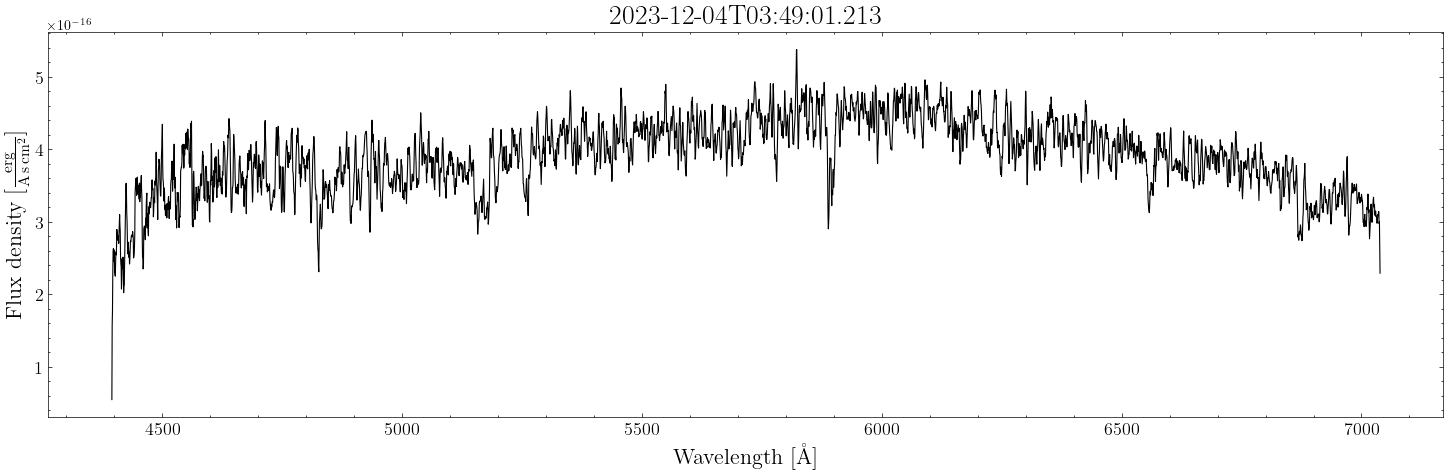

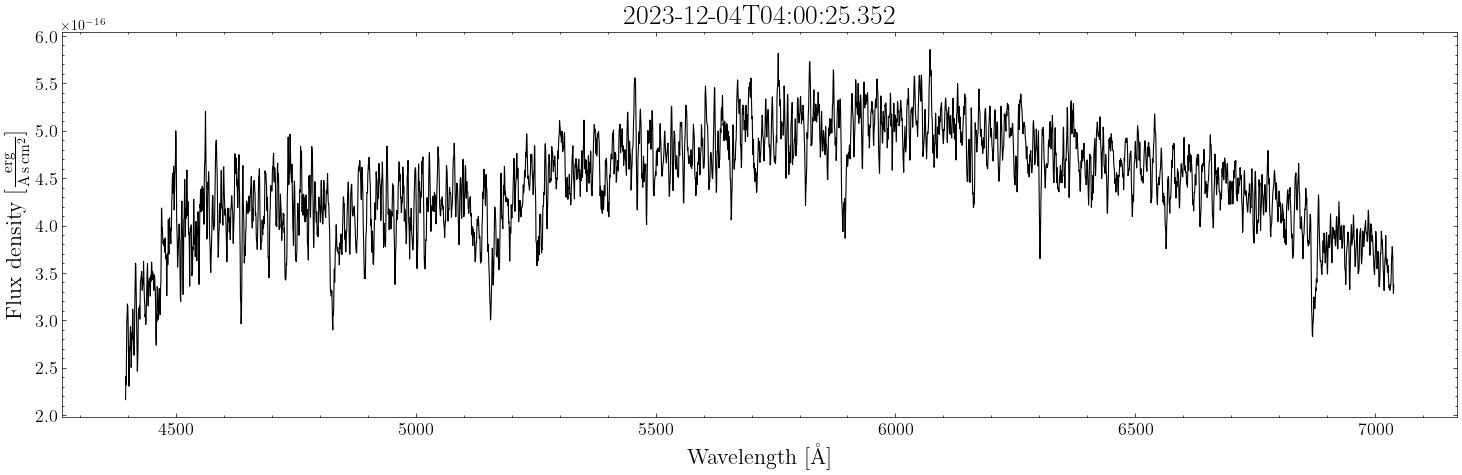

In [44]:
for f in os.listdir(DATA_DIR):
	if os.path.isdir(os.path.join(DATA_DIR, f)):
		continue

	s: Spectrum1D = Spectrum1D.read(os.path.join(DATA_DIR, f))
	specHdul = fits.open(os.path.join(DATA_DIR, f))[0]
	print(s.spectral_axis[0], s.spectral_axis[-1])
	print(s.uncertainty)
	specUtcTimeObs = Time(specHdul.header['DATE-OBS'], scale='utc') + (specHdul.header['UTC-TAI']*u.second)

	plt.figure(figsize=(18, 5))
	plt.plot(s.spectral_axis, s.flux, linewidth=0.8, c='black')
	plt.title(specUtcTimeObs, fontsize=20)
	plt.xlabel(f"Wavelength [{s.spectral_axis.unit._repr_latex_()}]", fontsize=16)
	plt.ylabel(f"Flux density [{s.flux.unit._repr_latex_()}]", fontsize=16)
	plt.tick_params(axis='both', labelsize=13)

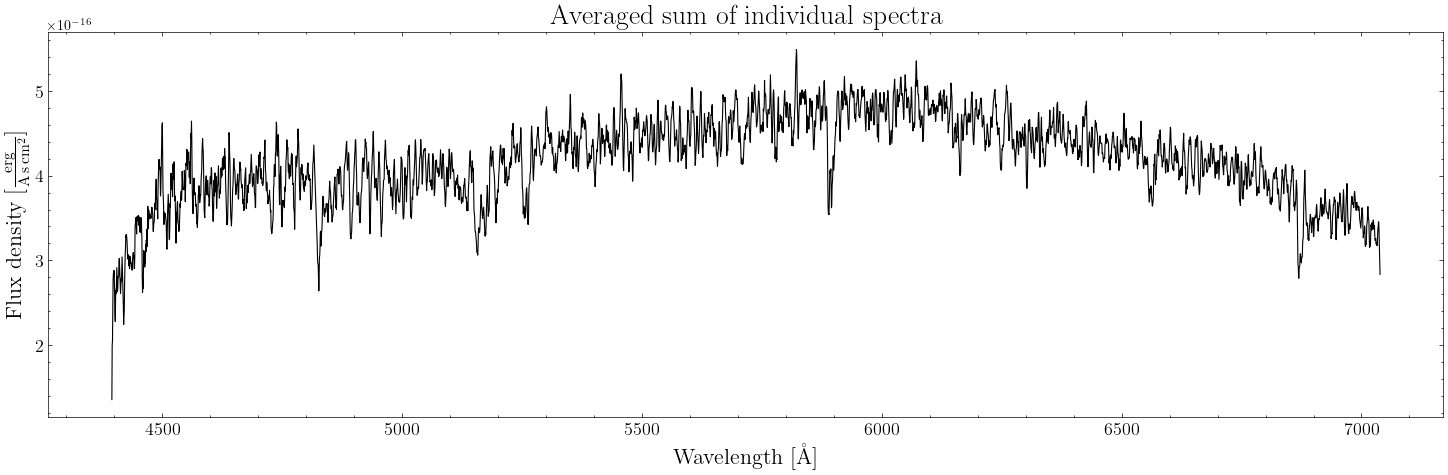

In [45]:
plt.figure(figsize=(18, 5))
plt.plot(spec.spectral_axis, spec.flux, linewidth=0.8, c='black')
plt.title("Averaged sum of individual spectra", fontsize=20)
plt.xlabel(f"Wavelength [{spec.spectral_axis.unit._repr_latex_()}]", fontsize=16)
plt.ylabel(f"Flux density [{spec.flux.unit._repr_latex_()}]", fontsize=16)
plt.tick_params(axis='both', labelsize=13)

# Extinction Analysis

In [31]:
# blackbody test
import numpy as np
from astropy.modeling.models import BlackBody
import astropy.units as u

# wavelengths and spectrum are 1D arrays
# wavelengths between 1000 and 30000 A
wavelengths = np.logspace(np.log10(1000), np.log10(3e4), num=1000)*u.AA
bb_lam = BlackBody(10000*u.K, scale=1.0 * u.erg / (u.cm ** 2 * u.AA * u.s * u.sr))
spectrum = bb_lam(wavelengths)

# Continuum Fitting and Spectral Line Analysis

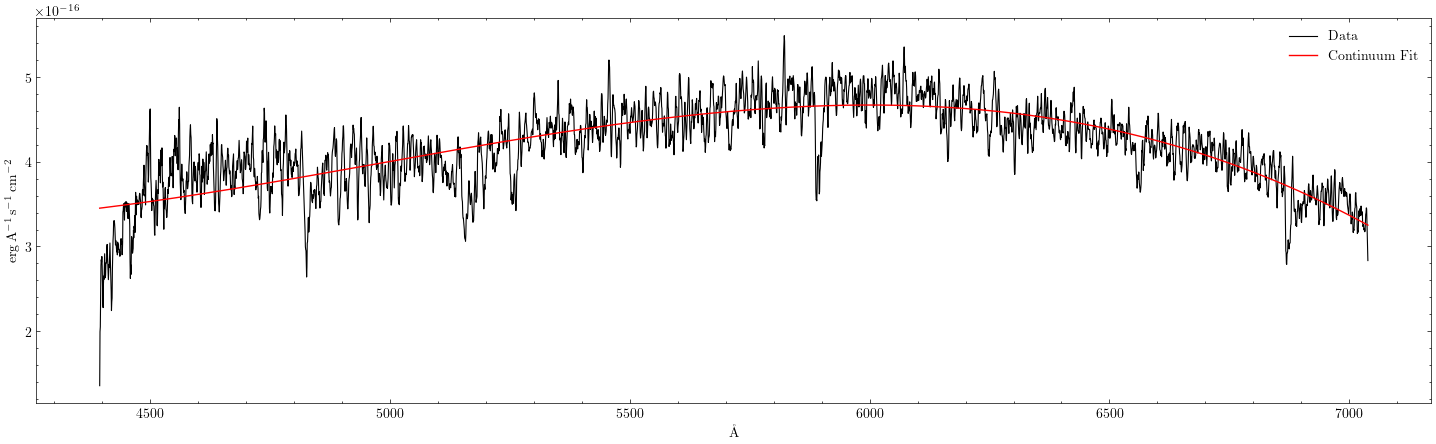

In [32]:
from specutils.fitting import fit_generic_continuum

generif_fit = fit_generic_continuum(spec)
specContinuum = generif_fit(spec.spectral_axis)

plt.figure(figsize=(18, 5))
plt.plot(spec.spectral_axis, spec.flux, linewidth=0.8, label='Data', color='black')
plt.plot(spec.spectral_axis, specContinuum, label='Continuum Fit', color='red')
plt.legend()

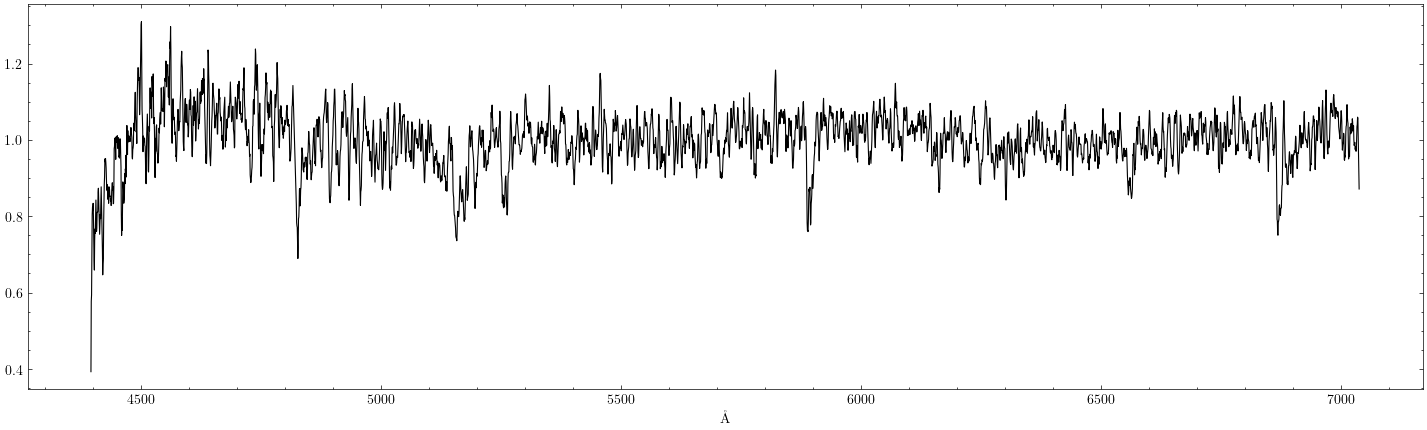

In [33]:
spec_norm = spec / specContinuum

plt.figure(figsize=(18, 5))
plt.plot(spec_norm.spectral_axis, spec_norm.flux, linewidth=0.8, color='black')

Spectrum1D (length=4095)
Flux=[0.3927788  0.57701915 0.59385833 ... 0.98167532 0.91562916
      0.87131688] ,  mean=1.00004
Spectral Axis=[4395.16848272 4395.81418765 4396.45989259 ... 7037.3930883
               7038.03879324 7038.68449818] Angstrom,  mean=5716.92649 Angstrom
Uncertainty=StdDevUncertainty ([0.04756255 0.04756255 0.04756255 ... 0.04756255 0.04756255 0.04756255] )



If you want to suppress this warning either type 'specutils.conf.do_continuum_function_check = False' or see http://docs.astropy.org/en/stable/config/#adding-new-configuration-items for other ways to configure the warning. [specutils.analysis.flux]


line_center,line_type,line_center_index
Angstrom,,
float64,str8,int64
4399.688417280887,emission,7
4405.499761721328,emission,16
4410.665401223942,emission,24
4416.476745664383,emission,33
4450.053402431375,emission,85
4500.418387581862,emission,163
4940.143450241886,emission,844
5159.683129102985,emission,1184


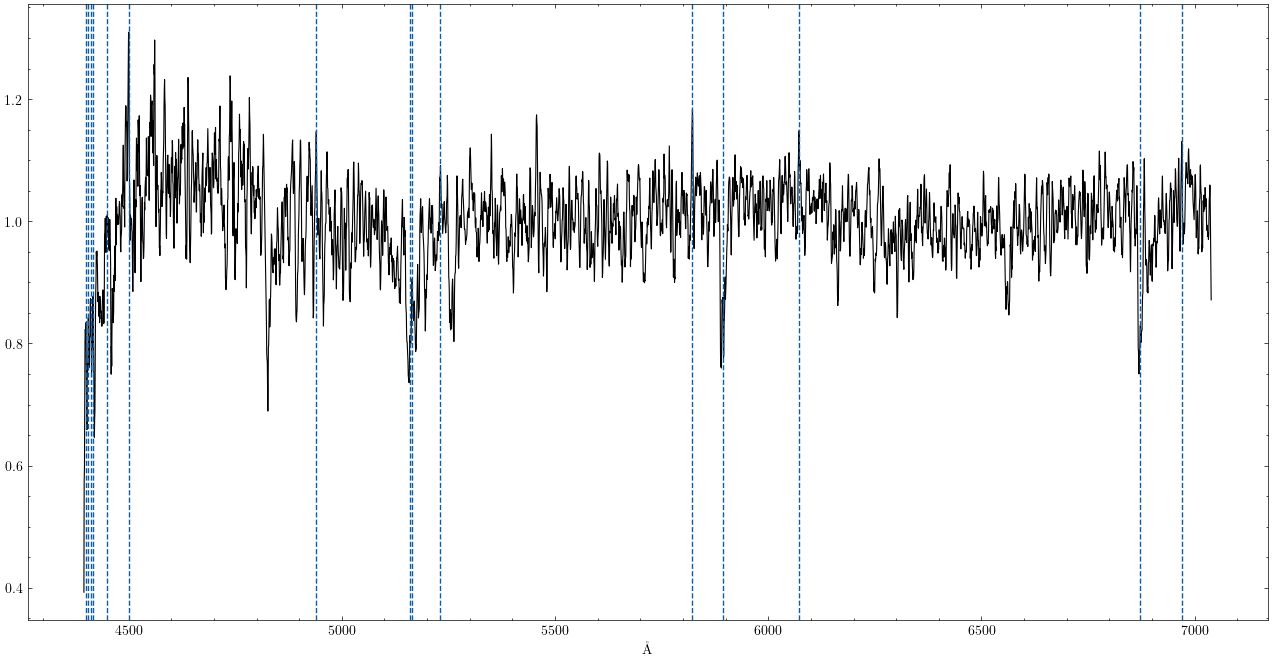

In [34]:
from specutils.manipulation import noise_region_uncertainty
from specutils.fitting import find_lines_threshold, find_lines_derivative

noise_region = SpectralRegion(5500*u.AA, 5800*u.AA)
spectrumNoise = noise_region_uncertainty(spec_norm, noise_region)
print(spectrumNoise)

lines = find_lines_threshold(spectrumNoise, noise_factor=17)  
# lines = find_lines_derivative(spec_norm, flux_threshold=1.1)

plt.figure(figsize=(16, 8))
plt.plot(spec_norm.spectral_axis, spec_norm.flux, linewidth=0.8, color='black')

for row in lines:
	plt.axvline(row['line_center'].value, linestyle='dashed')
lines

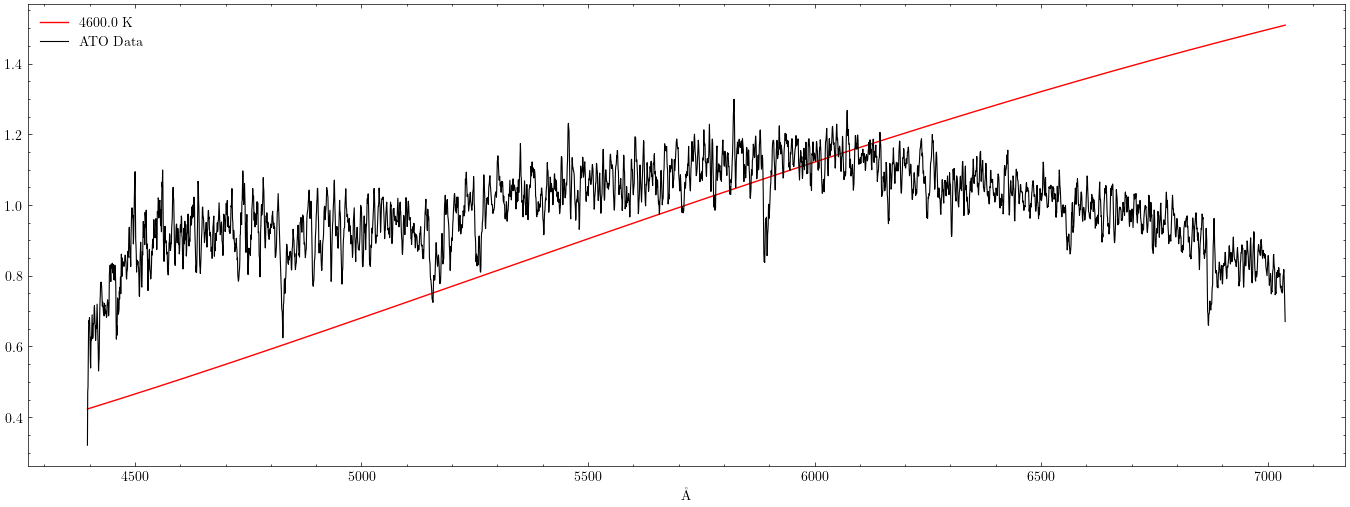

In [65]:
temperature = 4600*u.K
bb = BlackBody(temperature=temperature)
flux = bb(spec.spectral_axis)

plt.figure(figsize=(17, 6))
plt.plot(spec.spectral_axis, flux / np.median(flux), label=temperature, color='red')
plt.plot(spec.spectral_axis, spec.flux / np.median(spec.flux), label='ATO Data',color='black', lw=0.8)
plt.legend()
plt.show()